In [509]:
# Импортируем основные библиотеки
import pandas as pd
import numpy as np
from tqdm import tqdm
import shap
import joblib

import warnings

warnings.filterwarnings("ignore")

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Preprocessing
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb


# Metrics
from sklearn.metrics import mean_squared_error


# tunning hyperparamters model
import optuna

from tabulate import tabulate

# Подгружаем отображение графиков
from graphs import display_cat_features, display_corr, get_report, display_nan, display_target, display_zero

# Подгружаем препроцессинг для наших данных
from preprocessing import Preprocessor

In [510]:
# Включаем настройку для отображения всех столбцов датафреймов
pd.set_option("display.max_columns", None)

In [511]:
# Читаем тренировочные данные
graph_data = pd.read_csv("train.csv")
graph_data_cat = graph_data.select_dtypes("object")

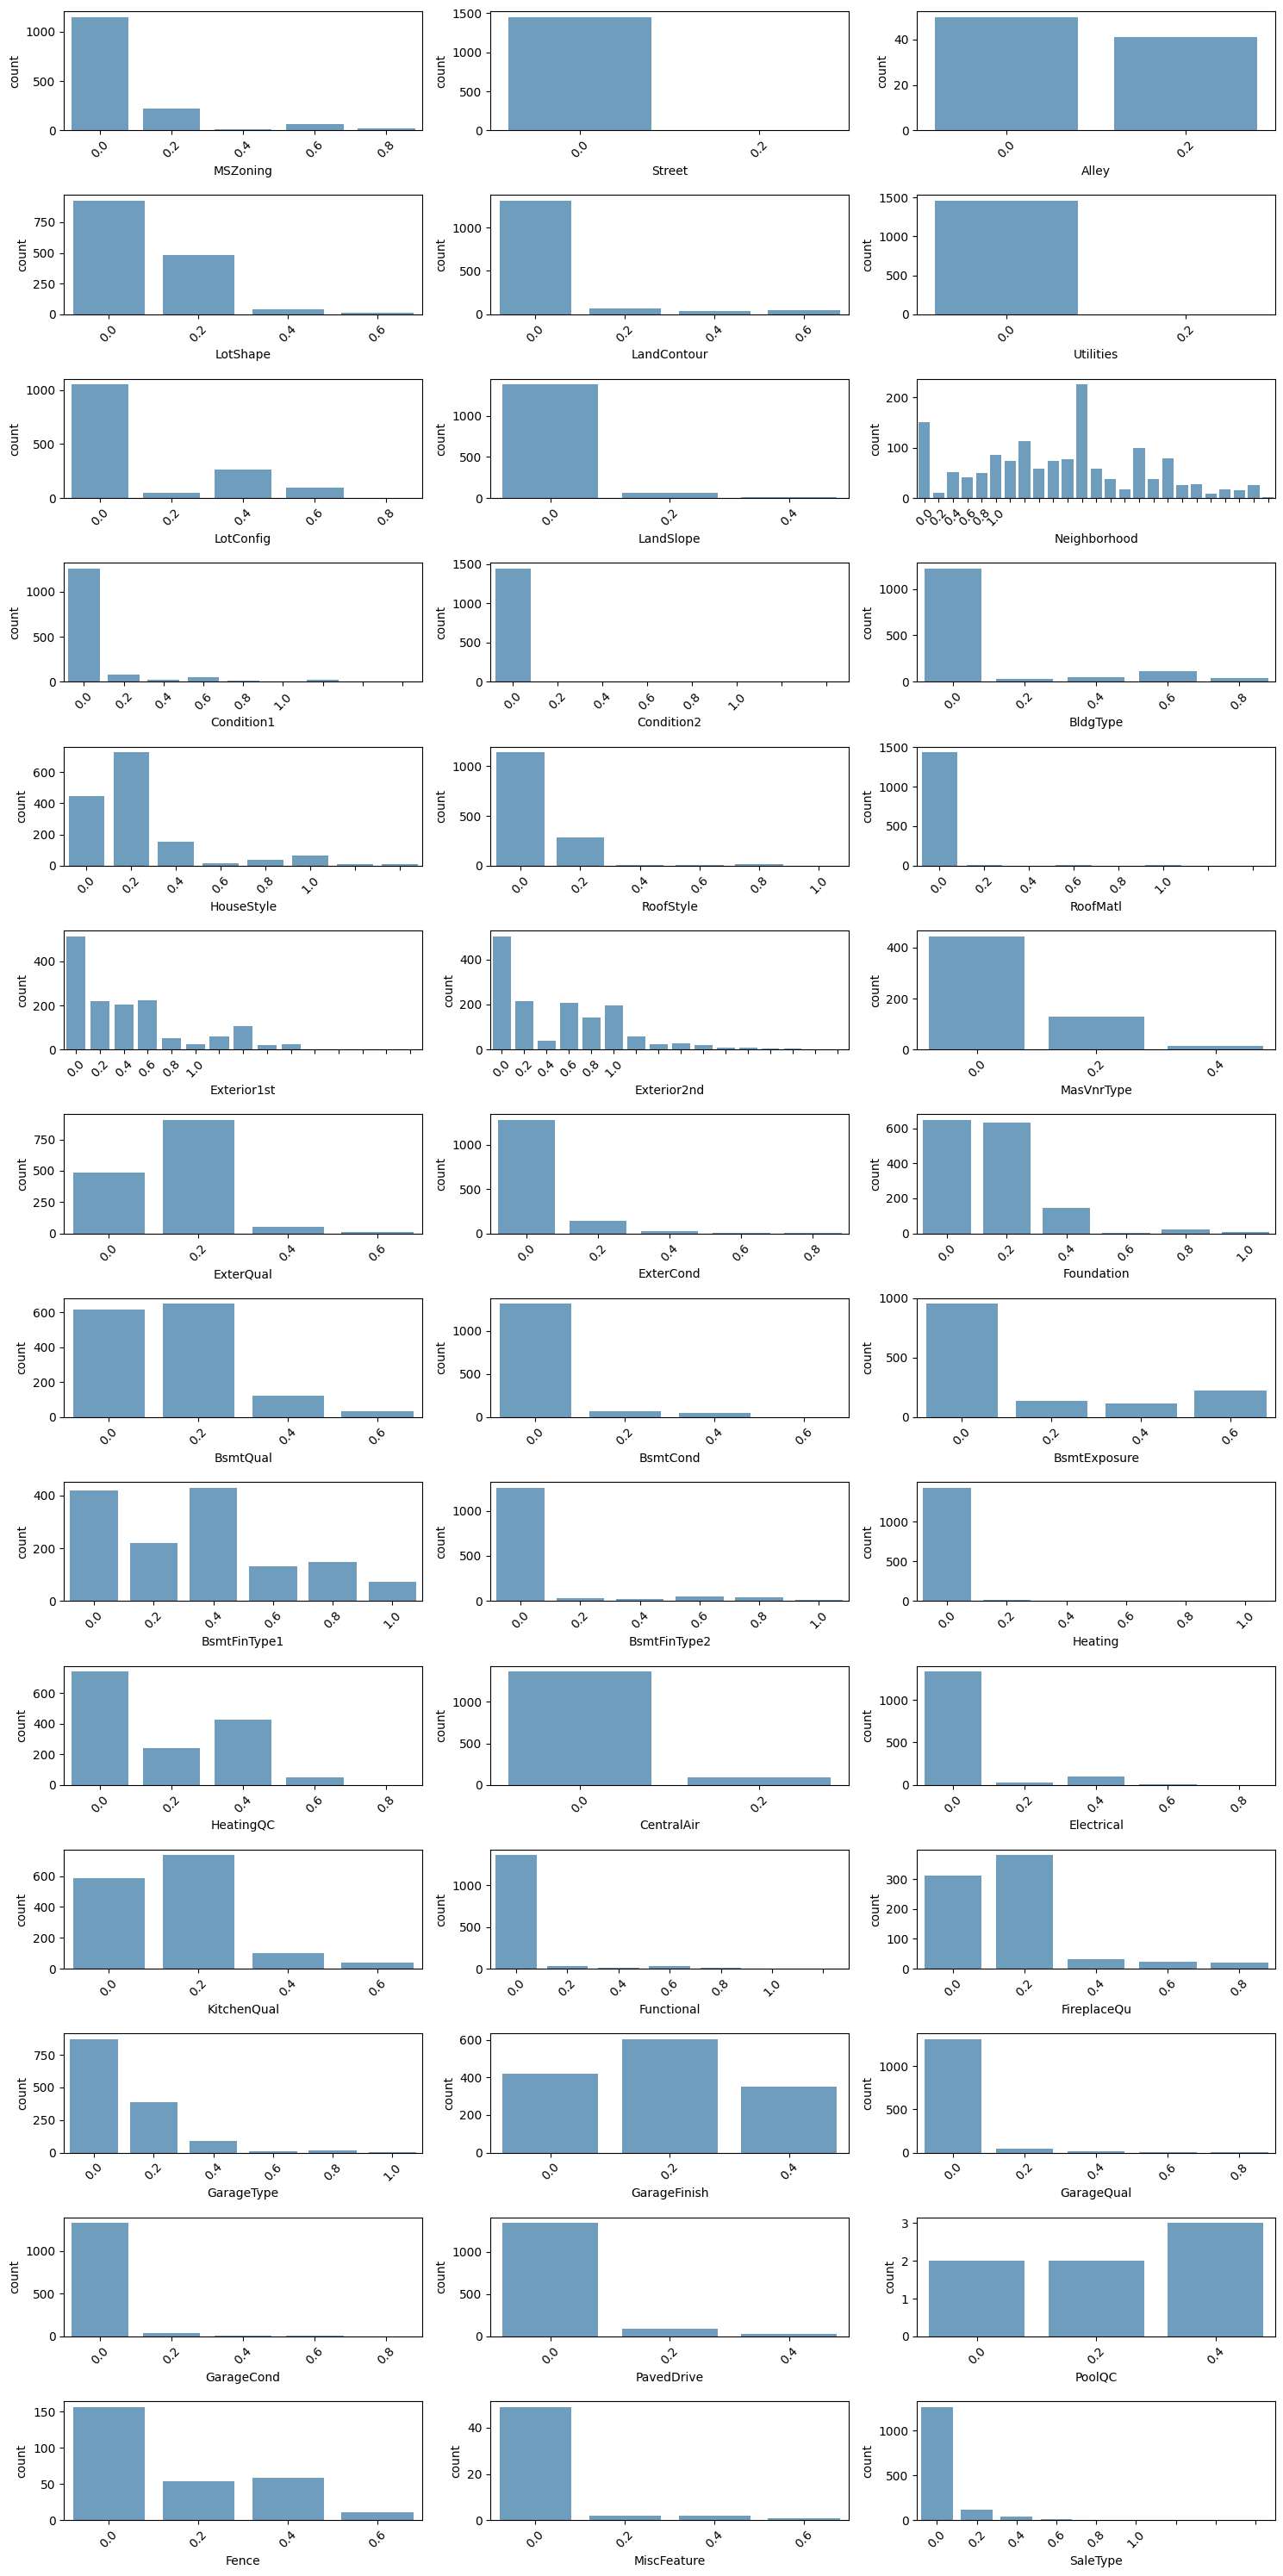

In [215]:
#Распределение категориальные признаки
display_cat_features(graph_data_cat)

In [216]:
# Получаем отчет по нашим данным
get_report(graph_data)

                                             |               | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


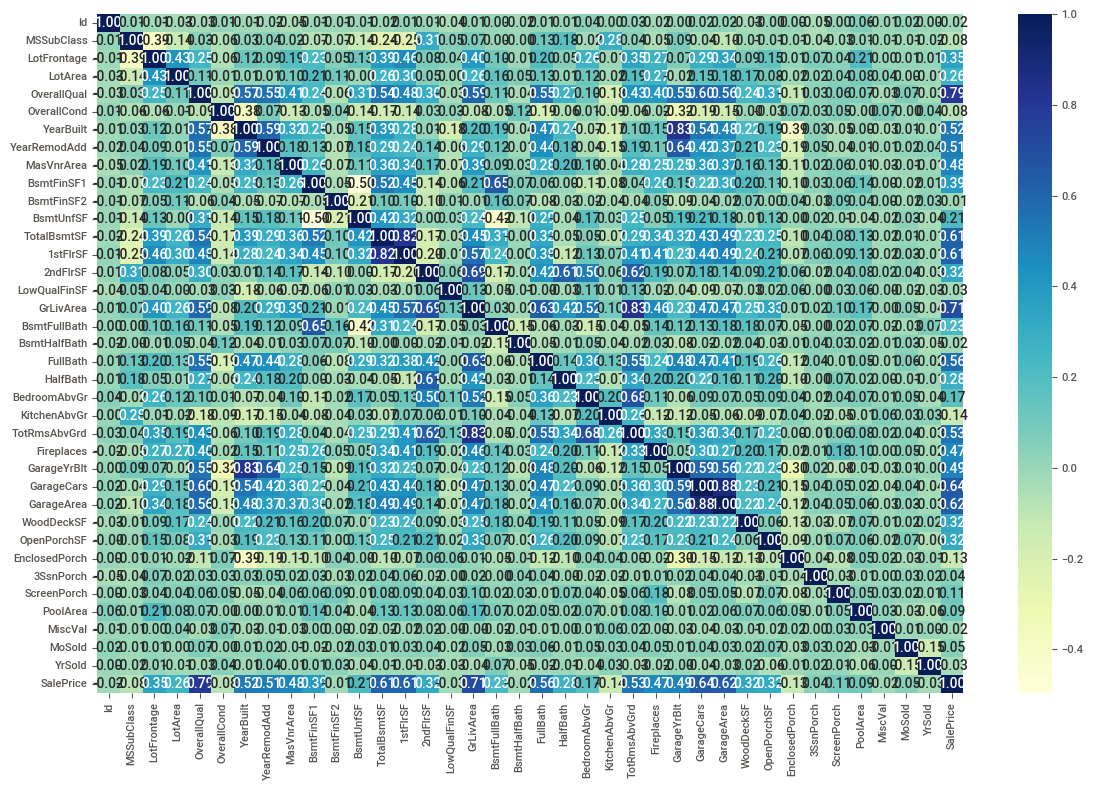

In [217]:
# Строим матрицу корреляций
display_corr(graph_data)

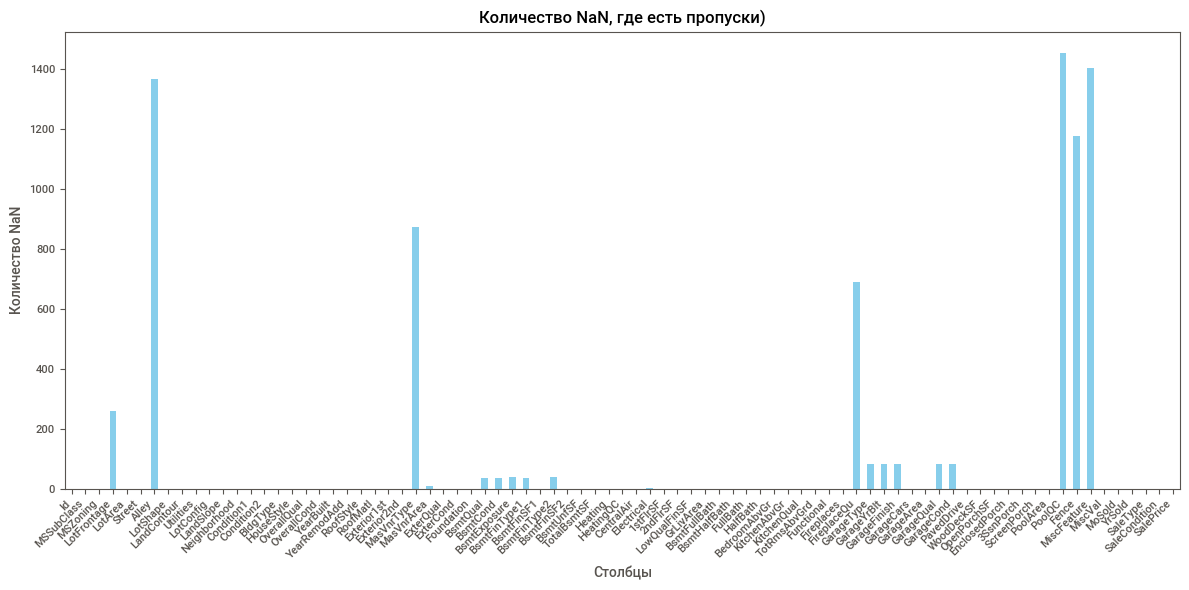

In [218]:
display_nan(graph_data)

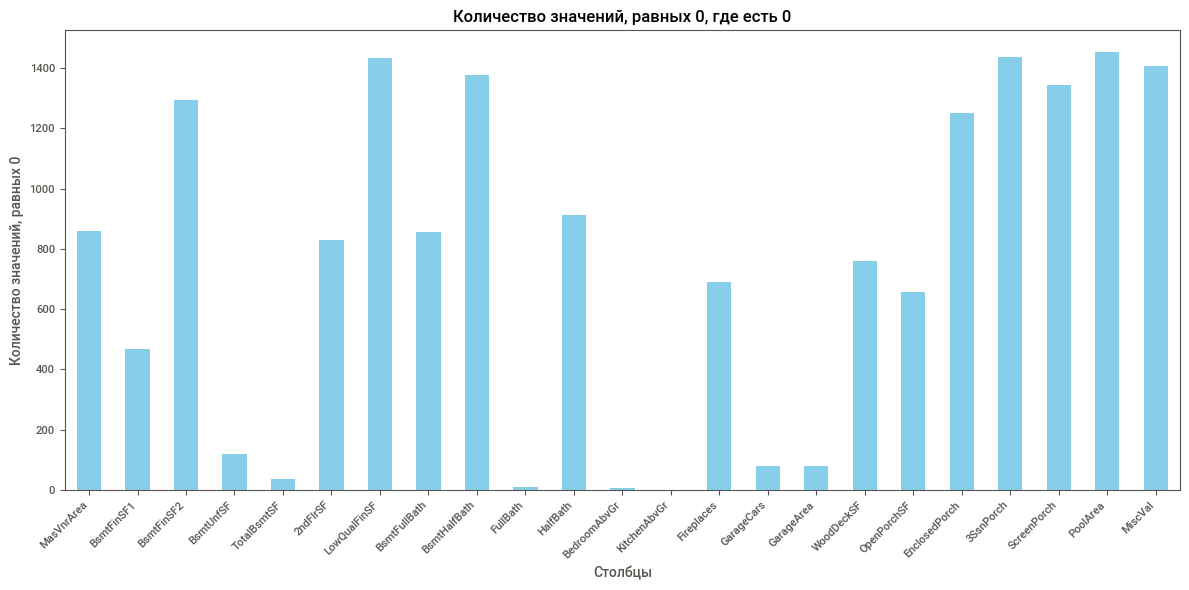

In [219]:
#·Отображаем·сколько·нулей·там,·где·есть·нули
display_zero(graph_data)

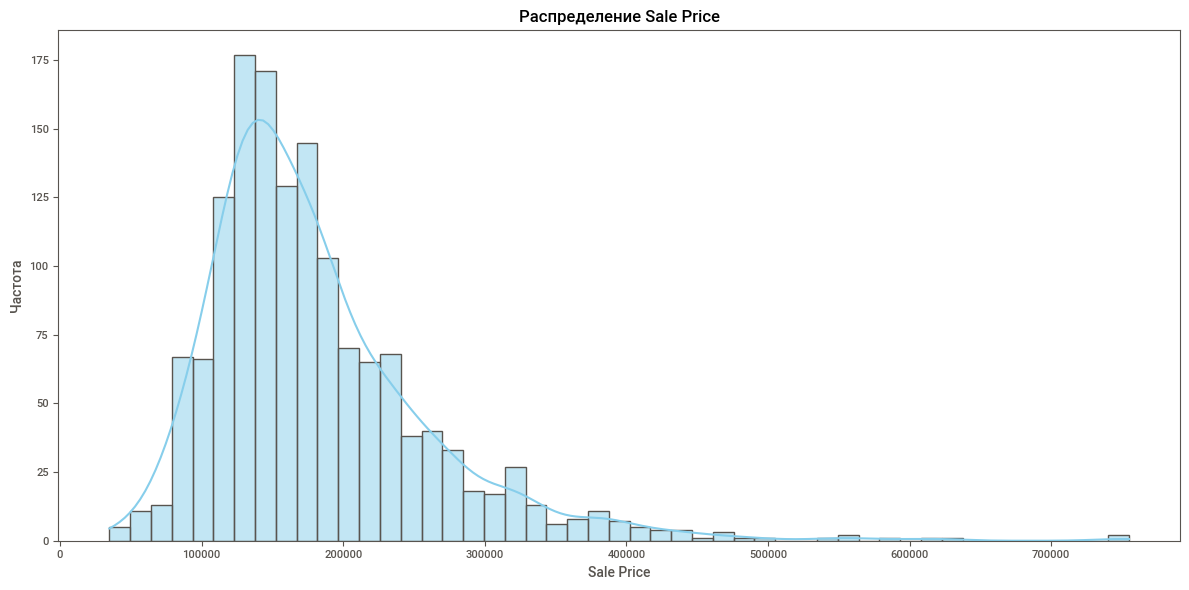

In [220]:
# Отображаем распределение целевого признака
display_target(graph_data)

In [513]:
# Загружаем датасет
df_train, df_test = pd.read_csv("train.csv"), pd.read_csv("test.csv")


# Cохраняем id, оно пригодится нам позднее
id = df_test["Id"]

# Отделяем таргет от признаков
df_train, y = df_train.drop("SalePrice", axis=1), df_train["SalePrice"] 

# Проверяем на дубликаты
df_train.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

In [514]:
# Собираем тестовые и тренировоные данные вместе для препроцессинга
df = pd.concat((df_train, df_test), ignore_index=True, axis=0)
# Удаляем Id, так как на окончательный результат он точно не влияет
df.drop("Id", axis=1, inplace=True)

In [515]:
# Получаем список колонок с NaN объектами и их количеством
df_nan = df.isna().sum()[df.isna().sum() > 0]
df_nan.sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

#### Смотрим на описание данных и что пропущенные значения из себя представляют.
> PoolQC: Pool quality \
       NA - No Pool

> MiscFeature: Miscellaneous feature not covered in other categories \
       NA - None

> Alley: Type of alley access to property \
       NA - No alley access

> Fence: Fence quality \
       NA - No Fence

> MasVnrType: Masonry veneer type \
       None - None

> FireplaceQu: Fireplace quality \
       NA - No Fireplace

> LotFrontage: Linear feet of street connected to property \
       Нет дополнительной информации.

> GarageFinish: Interior finish of the garage \
       NA - No Garage

> GarageQual: Garage quality \
       NA - No Garage

> GarageCond: Garage condition \
       NA - No Garage

> GarageYrBlt: Year garage was built

> GarageType: Garage location \
       NA - No Garage

> BsmtExposure: Refers to walkout or garden level walls \
       NA - No Basement

> BsmtCond: Evaluates the general condition of the basement \
       NA - No Basement

> BsmtQual: Evaluates the height of the basement \
       NA - No Basement

> BsmtFinType2: Rating of basement finished area (if multiple types) \
       NA - No Basement

> BsmtFinType1: Rating of basement finished area \
       NA - No Basement

> MasVnrArea: Masonry veneer area in square feet \
       Нет дополнительной информации.

> MSZoning: Identifies the general zoning classification of the sale. \
       Нет дополнительной информации.

> BsmtFullBath: Basement full bathrooms \
       Нет дополнительной информации.

> BsmtHalfBath: Basement half bathrooms \
       Нет дополнительной информации.

> Functional: Home functionality (Assume typical unless deductions are warranted)

> Utilities: Type of utilities available \
       Нет дополнительной информации.

> GarageArea: Size of garage in square feet \
       Нет дополнительной информации.

> GarageCars: Size of garage in car capacity \
       Нет дополнительной информации.

> Electrical: Electrical system \
       Нет дополнительной информации.

> KitchenQual: Kitchen quality \
       Нет дополнительной информации.

> TotalBsmtSF: Total square feet of basement area \
       Нет дополнительной информации.

> Unfinished square feet of basement area \
       Нет дополнительной информации.

> BsmtFinSF2: Type 2 finished square feet \
       Нет дополнительной информации.

> BsmtFinSF1: Type 1 finished square feet \
       Нет дополнительной информации.

> Exterior1st: Exterior covering on house \
       Нет дополнительной информации.

> Exterior2nd: Exterior covering on house (if more than one material) \
       Нет дополнительной информации.

> SaleType: Type of sale \
       Нет дополнительной информации.

In [518]:
# Предобрабатываем наши данные
preprocessor = Preprocessor()
preprocessed_df = preprocessor.fit_transform(merged_df, y)

# Разъединяем наши данные для обучения модели и дальнейшей обработки
preprocessed_train, preprocessed_test = preprocessed_df.iloc[:1460, :], preprocessed_df.iloc[1460:, :]

In [519]:
# Предобрабатываем наши данные
preprocessor = Preprocessor()
preprocessed_df = preprocessor.fit_transform(df, y)

# Разъединяем наши данные для обучения модели и дальнейшей обработки
preprocessed_train, preprocessed_test = preprocessed_df.iloc[:1460, :], preprocessed_df.iloc[1460:, :]

In [152]:
# Обучаем модель и сохраняем результат
params = {
    "learning_rate": 0.1,
    "depth": 6,
    "l2_leaf_reg": 3,
    "random_seed": 42,
    "loss_function": "RMSE",
    "verbose": 0,
    "early_stopping_rounds": 50,
}

cat_boost_rg = CatBoostRegressor(**params)
cat_boost_rg.fit(preprocessed_train, y)

predictions = np.expm1(cat_boost_rg.predict(preprocessed_test))
predictions = pd.Series(predictions)

submission = pd.concat((id, predictions), axis=1)
submission.columns = ['Id',	'SalePrice']
submission.to_csv("submission1.csv", index=False)

In [520]:
# Модель работает,  но попытаемся улучшить метрики. Сначала посмотрим на показатели нащих метрик на текущей модели и данных
# Получим данные для валидации и обучим нашу модель
train, valid, y_train, y_valid = train_test_split(preprocessed_train, np.array(y), test_size=0.2, random_state=42)
y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)

params = {
    "learning_rate": 0.1,
    "depth": 6,
    "l2_leaf_reg": 3,
    "random_seed": 42,
    "loss_function": "RMSE",
    "verbose": 0,
    "early_stopping_rounds": 50,
    "eval_metric": "RMSE"
}
cat_boost_rg = CatBoostRegressor(**params)
cat_boost_rg.fit(train, y_train, eval_set=(valid, y_valid));

In [521]:
best_score = cat_boost_rg.get_best_score()
print(f"Best RMSE is {best_score['validation']['RMSE']:.5f}")

Best RMSE is 0.12719


In [9]:
# Используем RFE чтобы отранжировать наши данные
rfe = RFE(cat_boost_rg, n_features_to_select=5)
rfe.fit(train, y_train)

RFE(estimator=<catboost.core.CatBoostRegressor object at 0x2b043eb00>,
    n_features_to_select=5)

In [155]:
ranking = rfe.ranking_

In [13]:
# Используем optuna для настройки оптимальных параметров

best_params = []
best_values = []

for i in range(round(len(ranking)/2)):
    train, valid, y_train, y_valid = train_test_split(preprocessed_train, np.array(y), test_size=0.2, random_state=42)
    
    y_train = np.log1p(y_train)
    y_valid = np.log1p(y_valid)
    
    def objective(trial):
        regressors = ["RandomForest", "Catboost", "LinearRegression", "SVR", "KNN", "XGBoost", "lgb"] 
    
        regressor_name = trial.suggest_categorical("regressor", regressors)
        
        if regressor_name == "RandomForest":
            model_params = {
                    "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
                    "max_depth": trial.suggest_int("max_depth", 3, 10),
                    "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
                    "max_features": trial.suggest_float("max_features", 0.1, 1.0),
                    "random_state": 42,
                    "n_jobs": -1
                }
    
            model = RandomForestRegressor(**model_params)
            model.fit(train, y_train)
            y_pred = model.predict(valid)
            rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
            
        elif regressor_name == "LinearRegression":
            model_params = {
                    "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
                }
    
            model = LinearRegression(**model_params)
            model.fit(train, y_train)
            y_pred = model.predict(valid)
            rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
     
        elif regressor_name == "Catboost":
            model_params = {
                    "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5),
                    "depth": trial.suggest_int("depth", 3, 7),
                    "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2,6),
                    "random_seed": 42,
                    "loss_function": "RMSE",
                    "verbose": 0,
                    "early_stopping_rounds": 5,
                    "eval_metric": "RMSE",
                    "iterations":300
                }
            model = CatBoostRegressor(**model_params)
            model.fit(
                train,
                y_train,
                eval_set=(valid, y_valid)
                )
            
            rmse = model.best_score_["validation"]["RMSE"]
        elif regressor_name == "SVR":
        
            model_params = {
                'C': trial.suggest_float('C', 0.1, 10, log=True),
                'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', ]), #'sigmoid'
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            }
            
            model = SVR(**model_params)
            model.fit(train, y_train)
            
            y_pred = model.predict(valid)
            
            rmse = mean_squared_error(y_valid, y_pred, squared=False)

        elif regressor_name == "KNN":
        
            model_params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            }
            
            model = KNeighborsRegressor(**model_params)
            model.fit(train, y_train)
            
            y_pred = model.predict(valid)
            
            rmse = mean_squared_error(y_valid, y_pred, squared=False)

        elif regressor_name == "XGBoost":
        
            model_params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'random_state': 42,
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
            }
            dtrain = xgb.DMatrix(train, label=y_train)
            dvalid = xgb.DMatrix(valid, label=y_valid)
            
            model = xgb.train(model_params, dtrain, evals=[(dvalid, 'validation')], early_stopping_rounds=5, verbose_eval=False)
            
            rmse = model.best_score

        elif regressor_name == "lgb":
        
            model_params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                'random_state': 42,
                'objective': 'regression',
                'metric': 'rmse',
                "verbose" : -1
            }

            train_data = lgb.Dataset(train, label=y_train)
            valid_data = lgb.Dataset(valid, label=y_valid, reference=train_data)
            
            model = lgb.train(model_params, train_data,valid_sets=[valid_data], num_boost_round=50)
            
            rmse = model.best_score["valid_0"]["rmse"]
    
        
        return rmse

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize')
    
    study.optimize(objective, n_trials=500)
    
    best_param = study.best_params
    best_value = study.best_value
    best_params.append(study.best_params)
    best_values.append(study.best_value)
    
    print(f"Best value is {best_value} with {best_param} parameters on {len(ranking)} features")
    preprocessed_train = preprocessed_train.drop(preprocessed_train.columns[np.argmax(ranking)], axis=1)
    ranking = np.delete(ranking, np.argmax(ranking))
    



Best value is 0.12936930570431415 with {'regressor': 'SVR', 'C': 0.453636678308867, 'kernel': 'linear', 'gamma': 'scale'} parameters on 109 features
Best value is 0.12371476482371889 with {'regressor': 'Catboost', 'learning_rate': 0.22947201158405223, 'depth': 4, 'l2_leaf_reg': 5} parameters on 108 features
Best value is 0.12259319624083474 with {'regressor': 'Catboost', 'learning_rate': 0.2876168304594355, 'depth': 5, 'l2_leaf_reg': 4} parameters on 107 features
Best value is 0.12256252151613135 with {'regressor': 'Catboost', 'learning_rate': 0.2065300893634726, 'depth': 4, 'l2_leaf_reg': 3} parameters on 106 features
Best value is 0.12780308662967257 with {'regressor': 'SVR', 'C': 2.0194667945333293, 'kernel': 'linear', 'gamma': 'auto'} parameters on 105 features
Best value is 0.1184251308754889 with {'regressor': 'Catboost', 'learning_rate': 0.1325383549505493, 'depth': 6, 'l2_leaf_reg': 6} parameters on 104 features
Best value is 0.12198444903716557 with {'regressor': 'Catboost', '

In [522]:
# Смотрим самый лучшие параметеры
np.array(best_values)
best_param = best_params[np.argmin(best_values)]
best_param

{'regressor': 'Catboost',
 'learning_rate': 0.1325383549505493,
 'depth': 6,
 'l2_leaf_reg': 6}

Получились значения {'regressor': 'Catboost',
 'learning_rate': 0.1325383549505493,
 'depth': 6,
 'l2_leaf_reg': 6} на выборке из 104 признаков

Но можно попробовать cхожие по результату параметры с наименьшей выборкой для обработки других моделей
> Best value is 0.11995971697833205 with {'regressor': 'Catboost', 'learning_rate': 0.32709661173768534, 'depth': 3, 'l2_leaf_reg': 2} parameters on 56 features

In [157]:
#Уменьшаем нашу выборку до полученного значения фичей
for i in range(len(ranking) - 104):
    preprocessed_train = preprocessed_train.drop(preprocessed_train.columns[np.argmax(ranking)], axis=1)
    ranking = np.delete(ranking, np.argmax(ranking))

In [162]:
# Обучаем нашу модель на полученных данных
train, valid, y_train, y_valid = train_test_split(preprocessed_train, np.array(y), test_size=0.2, random_state=42)

y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)

params = {
    "learning_rate": 0.1325383549505493,
    "depth": 6,
    "l2_leaf_reg": 6,
    "random_seed": 42,
    "loss_function": "RMSE",
    "verbose": 0,
    "early_stopping_rounds": 50,
    "eval_metric": "RMSE"
}

cat_boost_rg = CatBoostRegressor(**params)
cat_boost_rg.fit(train, y_train, eval_set=(valid, y_valid))
best_rmse = cat_boost_rg.get_best_score()['validation']['RMSE']
print(f"Best RMSE is {best_rmse:.5f}");

Best RMSE is 0.11832


In [204]:
# Теперь попробуем применить optuna к другим моделям на нашей получившейся выборке
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)

    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)

    knn.fit(train, y_train)
    

    y_pred = knn.predict(valid)
    

    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse

# Create an Optuna study object
study = optuna.create_study(direction='minimize')

# Start the optimization process
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
print(f" Best params is ={study.best_params}")
KNN_params = study.best_params
study.best_value

 Best params is ={'n_neighbors': 10, 'weights': 'distance', 'p': 1}


0.223102040474727

In [205]:
def objective(trial):
    # Define hyperparameters to optimize
    alpha = trial.suggest_float('alpha', 0.0, 1.0)  # Regularization strength
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)  # Mixing parameter (0 for Ridge, 1 for Lasso)
    
    # Initialize Elastic Net regressor with hyperparameters
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    
    # Fit the model
    elastic_net.fit(train, y_train)
    
    # Predict on the validation set
    y_pred = elastic_net.predict(valid)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
    return rmse
# Create an Optuna study object
study = optuna.create_study(direction='minimize')

# Start the optimization process
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
print(f" Best params is ={study.best_params}")
elastic_net_params = study.best_params
study.best_value

 Best params is ={'alpha': 9.662972547610776e-05, 'l1_ratio': 0.1752445800203541}


0.13384431902383992

In [167]:
# Cобираем наши модели в ансамбль и смотрим удалось ли улучшить значения
cat_boost_params = {
    "learning_rate": 0.1325383549505493,
    "depth": 6,
    "l2_leaf_reg": 6,
    "random_seed": 42,
    "loss_function": "RMSE",
    "verbose": 0,
    "early_stopping_rounds": 50,
    "eval_metric": "RMSE"
}

rf_params = {
    "n_estimators": 200,  
    "max_depth": 10, 
    "min_samples_split": 2, 
    "min_samples_leaf": 2, 
    "max_features": 10, 
    "bootstrap": True 
}

estimators = [
    ("cat_boost", CatBoostRegressor(**cat_boost_params)),
    ("KNN", KNeighborsRegressor(**KNN_params)),
    ("elastic_net", ElasticNet(**elastic_net_params))
]

reg = StackingRegressor(
       estimators=estimators,
      final_estimator=RandomForestRegressor(**rf_params))


reg.fit(train, y_train)
y_pred = reg.predict(valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

0.12581599864896534

##### Метрика ухудшилась на несколько процентов, но, возможно можно улучшить метрику подобрав гиперпараметры в optuna

In [185]:
def objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_int("max_features", 1, 20)
    }
    reg = StackingRegressor(
       estimators=estimators,
      final_estimator=RandomForestRegressor(**rf_params))
    reg.fit(train, y_train)
    y_pred = reg.predict(valid)
    
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse

study = optuna.create_study(direction="minimize")

# Start the optimization process
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
print(f" Best value is ={study.best_value}")

 Best value is =0.12085006358544746


In [170]:
# Штош, метрику улучшить не удалось, сохраняем cat_boost model на выборке из 104 элементов

predictions = np.expm1(cat_boost_rg.predict(preprocessed_test))
predictions = pd.Series(predictions)

submission = pd.concat((id, predictions), axis=1)
submission.columns = ['Id',	'SalePrice']
submission.to_csv("submission.csv", index=False)

model = joblib.dump(cat_boost_rg, "model.pkl")

In [171]:
best_rmse = cat_boost_rg.get_best_score()['validation']['RMSE']
print(f"Best RMSE is {best_rmse:.5f}");

Best RMSE is 0.11832


In [177]:
cat_boost_params

{'learning_rate': 0.1325383549505493,
 'depth': 6,
 'l2_leaf_reg': 6,
 'random_seed': 42,
 'loss_function': 'RMSE',
 'verbose': 0,
 'early_stopping_rounds': 50,
 'eval_metric': 'RMSE'}

In [179]:
elastic_net_params

{'alpha': 8.281232802921472e-05, 'l1_ratio': 0.16074532734422803}

In [186]:
study.best_params

{'n_estimators': 150,
 'max_depth': 9,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_features': 10}

In [206]:
cat_boost_params = {
    "learning_rate": 0.1325383549505493,
    "depth": 6,
    "l2_leaf_reg": 6,
    "random_seed": 42,
    "loss_function": "RMSE",
    "verbose": 0,
    "early_stopping_rounds": 50,
    "eval_metric": "RMSE"
}

rf_params = {'n_estimators': 150,
 'max_depth': 9,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_features': 10}

KNN_params = {'n_neighbors': 10, 'weights': 'distance', 'p': 1}

elastic_net_params = {'alpha': 9.662972547610776e-05, 'l1_ratio': 0.1752445800203541}



estimators = [
    ("cat_boost", CatBoostRegressor(**cat_boost_params)),
    ("KNN", KNeighborsRegressor(**KNN_params)),
    ("elastic_net", ElasticNet(**elastic_net_params))
]

def objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_int("max_features", 1, 20)
    }
    reg = StackingRegressor(
       estimators=estimators,
      final_estimator=RandomForestRegressor(**rf_params))
    reg.fit(train, y_train)
    y_pred = reg.predict(valid)
    
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse

study = optuna.create_study(direction="minimize")

# Start the optimization process
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
print(f" Best value is ={study.best_value}")

 Best value is =0.12153161686242792


In [208]:
study.best_params

{'n_estimators': 463,
 'max_depth': 7,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_features': 9}

In [210]:
# Cобираем наши модели в ансамбль и смотрим удалось ли улучшить значения
rf_params = {'n_estimators': 463,
 'max_depth': 7,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_features': 9}


reg = StackingRegressor(
       estimators=estimators,
      final_estimator=RandomForestRegressor(**rf_params))


reg.fit(train, y_train)
y_pred = reg.predict(valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

StackingRegressor(estimators=[('cat_boost',
                               <catboost.core.CatBoostRegressor object at 0x2e16c54b0>),
                              ('KNN',
                               KNeighborsRegressor(n_neighbors=10, p=1,
                                                   weights='distance')),
                              ('elastic_net',
                               ElasticNet(alpha=9.662972547610776e-05,
                                          l1_ratio=0.1752445800203541))],
                  final_estimator=RandomForestRegressor(max_depth=7,
                                                        max_features=9,
                                                        min_samples_leaf=7,
                                                        n_estimators=463))

In [ ]:
preprocessed_test.drop(["Alley_NA", "RoofMatl_Roll", "RoofStyle_Mansard", "RoofStyle_Shed", "Street_Pave"], inplace=True, axis=1)

In [211]:
predictions = np.expm1(reg.predict(preprocessed_test))
predictions = pd.Series(predictions)

submission = pd.concat((id, predictions), axis=1)
submission.columns = ['Id',	'SalePrice']
submission.to_csv("submission.csv", index=False)

In [423]:
# сохраняем модель
joblib.dump(reg, "model.pkl")

['model.pkl']